# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_IQ6PLUS-72-ACM-US [240V],inverter_model_1_SE3800H-US (240V),inverter_model_1_SE9KUS [208V],inverter_model_1_IQ7XS-96-E-ACM-US [240V],inverter_model_1_SE7600H-US (240V),inverter_model_1_SPR-X22-360-E-AC [208V],inverter_model_1_SE11400H-US (240V),inverter_model_1_IQ7-60-x-ACM-US [208V],inverter_model_1_SE10000H-US (240V),inverter_model_1_SB3.8-1SP-US-40 [208V]
351828,5.120,0.0,0,0.0,0.0,26.0,0.0,0.0,0.197531,16.0,...,0,0,0,0,0,0,0,0,0,0
391690,5.520,0.0,0,0.0,0.0,23.0,0.0,0.0,0.209255,16.0,...,0,0,0,0,0,0,0,0,0,0
397978,13.545,0.0,0,0.0,0.0,19.0,0.0,0.0,0.194085,43.0,...,0,0,0,0,0,0,0,0,0,0
455364,3.150,0.0,0,1.0,0.0,18.0,0.0,0.0,0.194444,1.0,...,0,0,0,0,0,0,0,0,0,0
382648,8.640,0.0,0,0.0,0.0,30.0,0.0,0.0,0.198895,24.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train.shape, y_train.shape

((156192, 400), (156192, 1))

In [5]:
X_train.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US [240V]',
       'inverter_model_1_SE3800H-US (240V)', 'inverter_model_1_SE9KUS [208V]',
       'inverter_model_1_IQ7XS-96-E-ACM-US [240V]',
       'inverter_model_1_SE7600H-US (240V)',
       'inverter_model_1_SPR-X22-360-E-AC [208V]',
       'inverter_model_1_SE11400H-US (240V)',
       'inverter_model_1_IQ7-60-x-ACM-US [208V]',
       'inverter_model_1_SE10000H-US (240V)',
       'inverter_model_1_SB3.8-1SP-US-40 [208V]'],
      dtype='object', length=400)

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. Since there isn't any reason large outliers should be extra harshly penalized, I'm going to rank the models based on mean absolute error (MAE), while plotting both MAE and root mean squared error (RMSE).

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.8)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((31238, 400), (124954, 400), (31238, 1), (124954, 1))

In [7]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

In [8]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_squared_error(y_te, y_pred)}
print(mean_squared_error(y_te, y_pred))

10171937.524198856


In [9]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10203845.984016448


In [10]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10933541.762749126


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [11]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

1.5868794190658323e+17


As expected, OLS produces a big improvement over the dummy regressors. I'll take a look at ridge regression to see if it will generate a better model.

In [12]:
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 100.53103351377021}

In [13]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

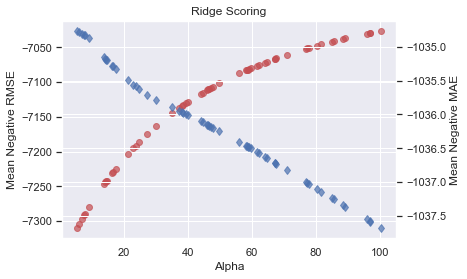

In [14]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
plt.title('Ridge Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [15]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10072873.525483882


So ridge regression performs almost the exact same as OLS, good to know. Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [16]:
parameters = {'alpha': sp_randFloat(1,100)}
lasso = linear_model.Lasso(random_state = 12)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 99.83738380592261}

In [17]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.210837,0.015406,0.012367,0.001353,55.88135,{'alpha': 55.88135039273247},-4054.777427,-1844.616456,-1643.375806,-26066.531667,...,9552.003128,30,-1087.759746,-1072.864313,-1043.799789,-1370.826234,-1049.840260,-1125.018069,123.917685,38
1,0.195676,0.014582,0.012367,0.001850,72.518937,{'alpha': 72.51893663724195},-4034.248063,-1797.045392,-1598.040748,-26066.251348,...,9572.671507,15,-1080.524258,-1064.899034,-1034.925993,-1381.144631,-1034.802887,-1119.259361,132.124457,19
2,0.197671,0.018705,0.012168,0.001596,61.276338,{'alpha': 61.276337607164386},-4046.968405,-1825.450122,-1625.693879,-26066.418137,...,9560.289466,26,-1086.831622,-1070.876778,-1042.515525,-1374.303317,-1045.480971,-1124.001643,126.222243,33
3,0.239759,0.033439,0.013964,0.001785,55.488318,{'alpha': 55.48831829968969},-4055.397784,-1846.218035,-1644.891260,-26066.539896,...,9551.312001,31,-1087.869353,-1073.050478,-1043.922517,-1370.580015,-1050.211956,-1125.126864,123.736584,39
4,0.213629,0.015672,0.011369,0.000489,43.36548,{'alpha': 43.36547993389047},-4081.387972,-1908.127163,-1704.309057,-26066.538833,...,9524.572804,40,-1092.160642,-1080.166968,-1048.354194,-1358.559069,-1061.862618,-1128.220698,116.144141,55


C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002366B4B2A48> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002366B1FE648> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':


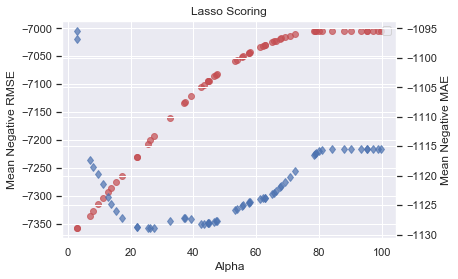

In [18]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

plt.title('Lasso Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [19]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

10093780.790068284


Again, almost the exact same performance relative to ridge and OLS regression. Next I'm going to take a look at random forest and see if that can produce a significant reduction in MAE.

In [20]:
parameters = {'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 9,
 'max_features': 0.4166403018066617,
 'min_samples_leaf': 683,
 'n_estimators': 998}

In [21]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_n_estimators', 'params',
       'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

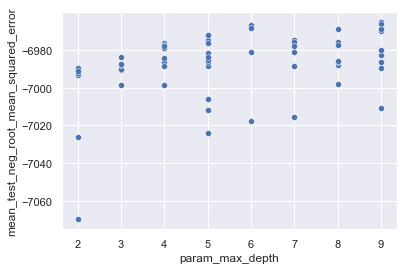

In [22]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_root_mean_squared_error')
plt.show()

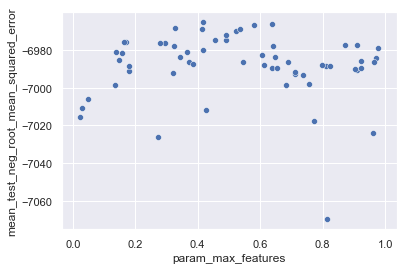

In [23]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_root_mean_squared_error')
plt.show()

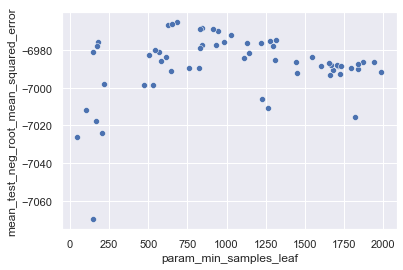

In [24]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_root_mean_squared_error')
plt.show()

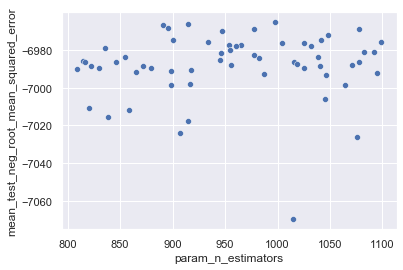

In [25]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_root_mean_squared_error')
plt.show()

In [26]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9921112.690533055

Nice, random forest improved upon the other models very significantly. I'll take a look at XGBoost next to see if it can improve even further.

In [27]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [28]:
x_tr.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US__240V_',
       'inverter_model_1_SE3800H-US_(240V)', 'inverter_model_1_SE9KUS__208V_',
       'inverter_model_1_IQ7XS-96-E-ACM-US__240V_',
       'inverter_model_1_SE7600H-US_(240V)',
       'inverter_model_1_SPR-X22-360-E-AC__208V_',
       'inverter_model_1_SE11400H-US_(240V)',
       'inverter_model_1_IQ7-60-x-ACM-US__208V_',
       'inverter_model_1_SE10000H-US_(240V)',
       'inverter_model_1_SB3.8-1SP-US-40__208V_'],
      dtype='object', length=400)

In [29]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
xgbooster.best_params_

{'colsample_bytree': 0.8515652870742079,
 'eta': 0.3663893539024105,
 'max_depth': 4,
 'n_estimators': 562}

In [30]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

580445337.1823267

In [31]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 1258}

In [32]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10018032.039388232

Interesting, even a basic decision tree outperformed the random forest and lasso regressors. Let's keep testing a few additional models to determine which should be tuned further and used as the final model.

In [33]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

{'n_neighbors': 29}

In [34]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10339623.762921793

In [35]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
opt_lgbm.best_params_

{'learning_rate': 0.0069093558684842895,
 'max_depth': 4,
 'n_estimators': 852,
 'num_leaves': 106}

In [36]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

14148588.676010579

Now that I've done a quick once-over for these different models and identified XGBoost as the best fit for this challenge, I'm going to revisit XGBoost and see if I can't refine it further to improve the results even more.

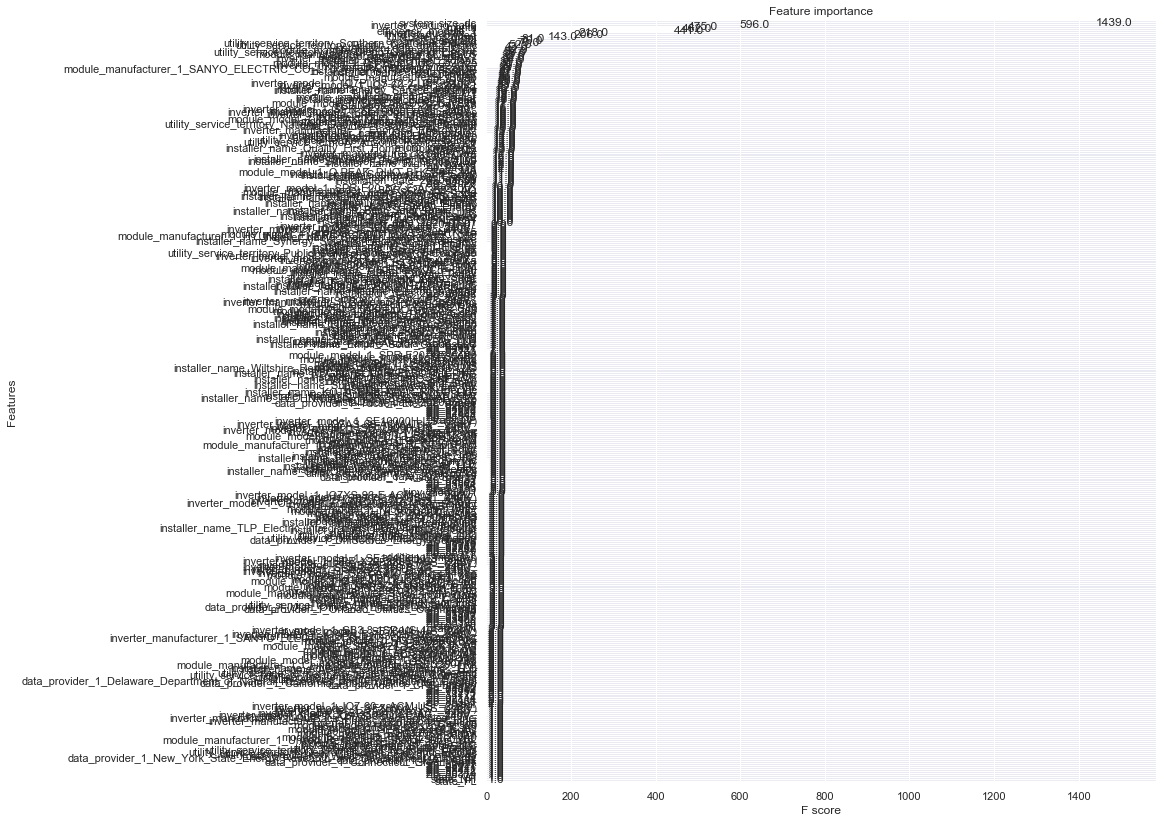

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model, ax=ax)

In [38]:
# Previous best parameters
# 'colsample_bytree': 0.9887415865233958,
# 'eta': 0.3412489908771189,
# 'max_depth': 9,
# 'n_estimators': 859

xgb_2 = XGBRegressor(verbosity = 0)
parameters = {'n_estimators': sp_randInt(759,959),
             'max_depth': sp_randInt(7,11),
             'eta': sp_randFloat(0.14,0.54),
             'colsample_bytree': sp_randFloat(0.9,1)} 
rand_xgb_2 = RandomizedSearchCV(xgb_2, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_2 = rand_xgb_2.fit(x_tr, y_tr)
xgbooster_2.best_params_

C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.05416 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.43374 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these pa

C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.42634 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.74802 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these pa

C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.44394 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 1.54373 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

  FitFailedWarning)
C:\Users\zbro1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these pa

{'colsample_bytree': 0.9823538341495615,
 'eta': 0.502411364914995,
 'max_depth': 10,
 'n_estimators': 901}

In [39]:
xgb_model_2 = XGBRegressor(n_estimators=xgbooster_2.best_params_['n_estimators'],\
                                   eta=xgbooster_2.best_params_['eta'],\
                                   colsample_bytree=xgbooster_2.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster_2.best_params_['max_depth'])
xgb_model_2.fit(x_tr, y_tr)
y_pred = xgb_model_2.predict(x_te)
train_scores['XGBoost 2'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

610687626.5877147

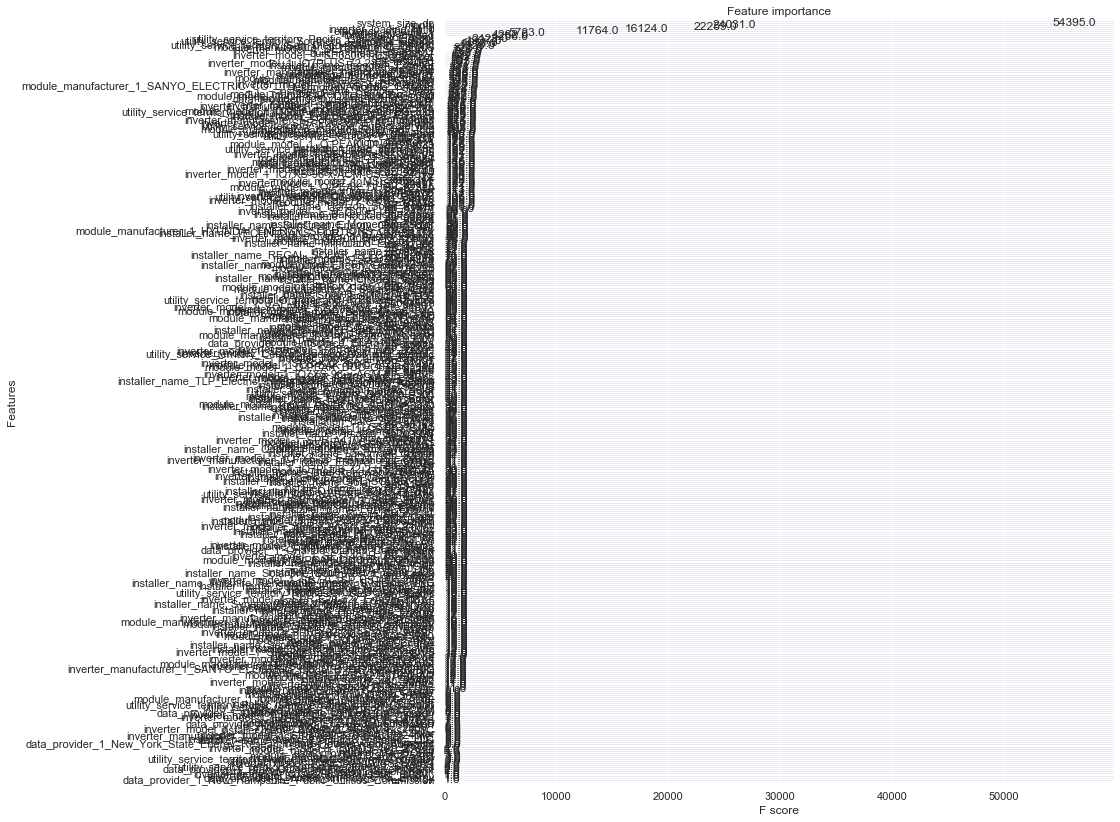

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model_2, ax=ax)

In [41]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'shuffle',
 'reg_alpha': 0.465508100172511,
 'reg_lambda': 0.03516826147080476}

In [42]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9849938.747217046

In [43]:
xgb_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'random',
 'reg_alpha': 0.3504782760049925,
 'reg_lambda': 0.03396417126592133}

In [44]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9846278.181131316

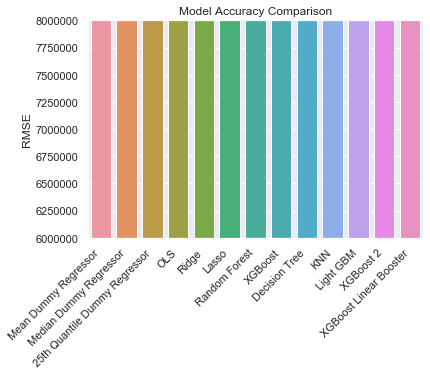

In [45]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(6000000,8000000)
plt.show()

In [46]:
print(np.quantile(y_train['price_per_kw'], 0.05))
print(np.quantile(y_train['price_per_kw'], 0.95))

1948.0855220799876
6077.570712746305


In [47]:
from sklearn.feature_selection import SelectFromModel

In [48]:
sel_ = SelectFromModel(ridge, prefit=True)
features = sel_.get_support()
x_tr_ridge = x_tr.iloc[:,features]
x_te_ridge = x_te.iloc[:,features]
x_tr_ridge.head()

,expansion_system,third_party_owned,self_installed,bipv_module_1,solar_storage_hybrid_inverter_1,state_CO,state_MD,zip_94533,zip_94941,zip_93561,...,inverter_model_1_SPR-E20-327-E-AC__208V_,inverter_model_1_X7602__240V_,inverter_model_1_IQ7XS-96-y-ACM-z__240V_,inverter_model_1_IQ7PLUS-72-x-ACM-US__208V_,inverter_model_1_SB5.0-1SP-US-40__208V_,inverter_model_1_SOLIVIA_5.2_NA_G4_TL__240V_,inverter_model_1_SE3800H-US_(240V),inverter_model_1_SE7600H-US_(240V),inverter_model_1_IQ7-60-x-ACM-US__208V_,inverter_model_1_SB3.8-1SP-US-40__208V_
365368,0,1.0,0.0,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
126266,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349768,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129491,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464214,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
sel_2 = SelectFromModel(lasso, prefit=True)
features = sel_2.get_support()
x_tr_lasso = x_tr.iloc[:,features]
x_te_lasso = x_te.iloc[:,features]
x_tr_lasso.head()

,system_size_dc,rebate_or_grant,tilt_1,inverter_quantity_1,month
365368,3.780,0.0,18.0,12.0,9
126266,14.720,0.0,18.0,1.0,9
349768,15.840,0.0,25.0,2.0,9
129491,12.350,0.0,18.0,38.0,9
464214,6.175,0.0,23.0,19.0,4


In [50]:
parameters = {'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
r_forest = RandomForestRegressor(n_jobs=-1, random_state=12)
r_forest_reg = RandomizedSearchCV(r_forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
ridge_forest = r_forest_reg.fit(x_tr_ridge, y_tr)
opt_ridge_forest = RandomForestRegressor(n_estimators=ridge_forest.best_params_['n_estimators'],\
                                   max_features=ridge_forest.best_params_['max_features'],\
                                   min_samples_leaf=ridge_forest.best_params_['min_samples_leaf'],\
                                   max_depth=ridge_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_ridge_forest.fit(x_tr_ridge, y_tr)
y_pred = opt_ridge_forest.predict(x_te_ridge)
train_scores['Random Forest Ridge Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10121560.378459737

In [51]:
parameters = {'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
l_forest = RandomForestRegressor(n_jobs=-1, random_state=12)
l_forest_reg = RandomizedSearchCV(l_forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
lasso_forest = l_forest_reg.fit(x_tr_lasso, y_tr)
opt_lasso_forest = RandomForestRegressor(n_estimators=lasso_forest.best_params_['n_estimators'],\
                                   max_features=lasso_forest.best_params_['max_features'],\
                                   min_samples_leaf=lasso_forest.best_params_['min_samples_leaf'],\
                                   max_depth=lasso_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_lasso_forest.fit(x_tr_lasso, y_tr)
y_pred = opt_lasso_forest.predict(x_te_lasso)
train_scores['Random Forest Lasso Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10046811.973759755

In [52]:
r_xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
ridge_xgb = RandomizedSearchCV(r_xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
r_xgbooster = ridge_xgb.fit(x_tr_ridge, y_tr)
r_xgb_model = XGBRegressor(n_estimators=r_xgbooster.best_params_['n_estimators'],\
                                   eta=r_xgbooster.best_params_['eta'],\
                                   colsample_bytree=r_xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=r_xgbooster.best_params_['max_depth'])
r_xgb_model.fit(x_tr_ridge, y_tr)
y_pred = r_xgb_model.predict(x_te_ridge)
train_scores['XGBoost Ridge Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10113401.955390582

In [53]:
l_xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
lasso_xgb = RandomizedSearchCV(l_xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
l_xgbooster = lasso_xgb.fit(x_tr_lasso, y_tr)
l_xgb_model = XGBRegressor(n_estimators=l_xgbooster.best_params_['n_estimators'],\
                                   eta=l_xgbooster.best_params_['eta'],\
                                   colsample_bytree=l_xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=l_xgbooster.best_params_['max_depth'])
l_xgb_model.fit(x_tr_lasso, y_tr)
y_pred = l_xgb_model.predict(x_te_lasso)
train_scores['XGBoost Lasso Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10193159.287803639

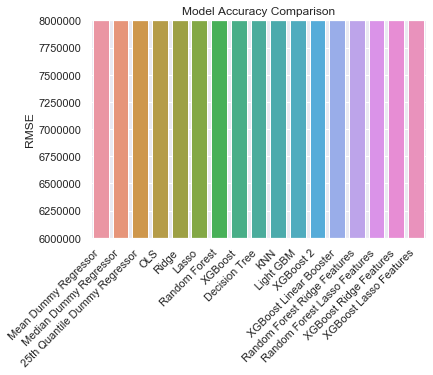

In [54]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(6000000,8000000)
plt.show()

In [55]:
xgb_r_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
ridge_xgb_linear = RandomizedSearchCV(xgb_r_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_ridge_linear = ridge_xgb_linear.fit(x_tr_ridge, y_tr)
xgb_ridge_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_ridge_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_ridge_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_ridge_linear.best_params_['feature_selector'])
xgb_ridge_linear.fit(x_tr_ridge, y_tr)
y_pred = xgb_ridge_linear.predict(x_te_ridge)
train_scores['XGBoost Ridge Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

9960915.97369964

In [56]:
xgb_l_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
lasso_xgb_linear = RandomizedSearchCV(xgb_l_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_lasso_linear = lasso_xgb_linear.fit(x_tr_lasso, y_tr)
xgb_lasso_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_lasso_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_lasso_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_lasso_linear.best_params_['feature_selector'])
xgb_lasso_linear.fit(x_tr_lasso, y_tr)
y_pred = xgb_lasso_linear.predict(x_te_lasso)
train_scores['XGBoost Lasso Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10095400.89751544

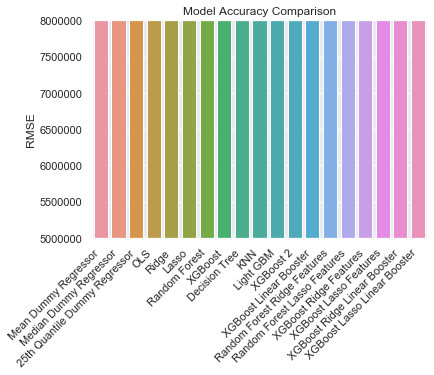

In [57]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(5000000,8000000)
plt.show()

In [58]:
r_lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
ridge_lgbm = RandomizedSearchCV(r_lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_ridge_lgbm = ridge_lgbm.fit(x_tr_ridge, y_tr)
lgbm_r_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_ridge_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_ridge_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_ridge_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_ridge_lgbm.best_params_['learning_rate'])
lgbm_r_opt.fit(x_tr_ridge, y_tr)
y_pred = lgbm_r_opt.predict(x_te_ridge)
train_scores['Light GBM Ridge'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

14868162.758778151

In [59]:
l_lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
lasso_lgbm = RandomizedSearchCV(l_lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lasso_lgbm = lasso_lgbm.fit(x_tr_lasso, y_tr)
lgbm_l_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lasso_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lasso_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lasso_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lasso_lgbm.best_params_['learning_rate'])
lgbm_l_opt.fit(x_tr_lasso, y_tr)
y_pred = lgbm_l_opt.predict(x_te_lasso)
train_scores['Light GBM Lasso'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

10403632.817204578

In [60]:
importances = pd.concat([pd.Series(xgb_model_linear.feature_importances_), pd.Series(opt_forest.feature_importances_),\
                       pd.Series(decision_tree_model.feature_importances_), pd.Series(lgbm_opt.feature_importances_)],\
                         keys = x_tr.columns) 
importances.head()

system_size_dc  0   -0.005006
                1   -0.000060
                2    0.056884
                3   -0.118950
                4   -0.095205
dtype: float64

In [61]:
importances.head()

system_size_dc  0   -0.005006
                1   -0.000060
                2    0.056884
                3   -0.118950
                4   -0.095205
dtype: float64

In [62]:
rf_top_ten = list(zip(opt_forest.feature_importances_, x_tr.columns))
rf_top_ten.sort(reverse=True)
rf_top_ten = rf_top_ten[0:10]
xgbl_top_ten = list(zip(xgb_model_linear.feature_importances_, x_tr.columns))
xgbl_top_ten.sort(reverse=True)
xgbl_top_ten = xgbl_top_ten[0:10]
print(rf_top_ten)

[(0.2824959332756724, 'system_size_dc'), (0.14236850434672635, 'installer_name_Vivint_Solar'), (0.09611069944752221, 'state_CO'), (0.0903848469539392, 'utility_service_territory_Public_Service_Company_of_Colorado'), (0.07915922831941874, 'third_party_owned'), (0.04961567890649129, 'rebate_or_grant'), (0.032050539477382504, 'efficiency_module_1'), (0.029740161554893535, 'month'), (0.019699406404897212, 'technology_module_1_Mono'), (0.017892986740204085, 'data_provider_1_California_Public_Utilities_Commission')]


In [63]:
print(xgbl_top_ten)

[(0.5525437, 'installation_date_2020-02-11'), (0.17624436, 'installer_name_Vivint_Solar'), (0.17361753, 'state_CO'), (0.173573, 'utility_service_territory_Public_Service_Company_of_Colorado'), (0.12619495, 'solar_storage_hybrid_inverter_1'), (0.085673176, 'installer_name_Infinity_Energy_Inc.'), (0.0777883, 'utility_service_territory_Consolidated_Edison'), (0.074147016, 'inverter_loading_ratio'), (0.06037548, 'inverter_manufacturer_1_SunPower'), (0.058504056, 'inverter_model_1_SE7600A-US__240V_')]
